# <Center>  **Exploratory Data Analysis**

## Loading Data and Packages

First import all of the necessary Modules

In [24]:
# Import the Data Science Essentials
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython import display
from kmodes.kprototypes import KPrototypes

from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

plt.style.use('dark_background')

In [5]:
# Find and set the working directory for this project
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

Load the Data

In [6]:
# Import the data
data = pd.read_csv('./data/interim/KDD Data.csv')
data = data.drop('Unnamed: 0', axis = 1)
num_only_data = pd.read_csv('./data/interim/Num Only Data.csv')
num_only_data = num_only_data.drop('Unnamed: 0', axis = 1)

## Basic Analysis

Many of the feature column names are not clear so it is important to define all the terms:
- **duration:** length (number of seconds) of the connection 	
    - continuous
- **protocol_type:** type of the protocol, e.g. tcp, udp, etc. 	
    - discrete
- **service:** network service on the destination, e.g., http, telnet, etc. 	
    - discrete
- **src_bytes:** number of data bytes from source to destination 	
    - continuous
- **dst_bytes:** number of data bytes from destination to source 	
    - continuous
- **flag:**	normal or error status of the connection 	 
    - discrete 
- **land:**	1 if connection is from/to the same host/port; 0 otherwise 	
    - discrete
- **wrong_fragment:** number of ``wrong'' fragments 	
    - continuous
- **urgent:** number of urgent packets 	
    - continuous
- **hot:** number of ``hot'' indicators	
    - continuous
- **num_failed_logins:** number of failed login attempts 	
    - continuous
- **logged_in:** 1 if successfully logged in; 0 otherwise 	 
    - discrete
- **num_compromised:** number of ``compromised'' conditions 	
    - continuous
- **root_shell:** 1 if root shell is obtained; 0 otherwise 	
    - discrete
- **su_attempted:** 1 if ``su root'' command attempted; 0 otherwise 	
    - discrete
- **num_root:**	number of ``root'' accesses 	
    - continuous
- **num_file_creations:** number of file creation operations 	
    - continuous
- **num_shells:** number of shell prompts 	
    - continuous
- **num_access_files:** number of operations on access control files 	
    - continuous
- **num_outbound_cmds:** number of outbound commands in an ftp session 	
    - continuous
- **is_hot_login:** 1 if the login belongs to the ``hot'' list; 0 otherwise 	
    - discrete
- **is_guest_login:** 1 if the login is a ``guest''login; 0 otherwise 	
    - discrete
- **count:** 	number of connections to the same host as the current connection in the past two seconds 	continuous
Note: The following  features refer to these same-host connections.	
- **serror_rate:** % of connections that have ``SYN'' errors 	
    - continuous
- **rerror_rate:** % of connections that have ``REJ'' errors 	
    - continuous
- **same_srv_rate:** % of connections to the same service 	
    - continuous
- **diff_srv_rate:** % of connections to different services 	
    - continuous
- **srv_count:** number of connections to the same service as the current connection in the past two seconds 	continuous
Note: The following features refer to these same-service connections.	
- **srv_serror_rate:** % of connections that have ``SYN'' errors 	
    - continuous
- **srv_rerror_rate:** % of connections that have ``REJ'' errors 	
    - continuous
- **srv_diff_host_rate:** % of connections to different hosts 	
    - continuous 


This dataset has a large number of independent variables that have slight. It's dependent variable is categorical with many categories that need some research to understand. The first thing to do is to research all of the categories of the dependent variable. To do this we can print out each of the types of network intrusion in the dataset in a format that can be used in markdown and ChatGPT

In [5]:
for type in data['labels'].unique():
    print(f"- {type}")

- normal.
- buffer_overflow.
- loadmodule.
- perl.
- neptune.
- smurf.
- guess_passwd.
- pod.
- teardrop.
- portsweep.
- ipsweep.
- land.
- ftp_write.
- back.
- imap.
- satan.
- phf.
- nmap.
- multihop.
- warezmaster.
- warezclient.
- spy.
- rootkit.


After plugging the above list into ChatGPT with the query "For each of these network intrusions can you please give a sentence summary describing what they are." It returned these explanations for each of the network intrusion types
- **normal:** This is not an attack type, but rather a classification used to indicate that the network traffic is within normal parameters.
- **buffer_overflow:** This attack occurs when a program or process attempts to store more data in a buffer than it was intended to hold, causing the excess data to overflow into adjacent memory locations.
- **loadmodule:** This type of attack involves the unauthorized loading of a module or plugin into a vulnerable system, which can then be used to gain further access or control over the system.
- **perl:** This is a type of attack that involves exploiting vulnerabilities in Perl scripts, which are often used to power web applications and other online services.
- **neptune:** This attack type involves overwhelming a targeted system with a flood of TCP packets, causing it to become unresponsive or crash.
- **smurf:** This attack type is similar to the neptune attack, but involves using a network of intermediary hosts to amplify the volume of traffic directed at the target system.
- **guess_passwd:** This attack type involves attempting to guess a user's password by systematically trying a large number of possible combinations.
- **pod:** This attack type involves sending malformed packets to a target system in order to cause it to crash or become unstable.
- **teardrop:** This is a type of attack that involves sending overlapping or malformed packets to a target system, causing it to crash or become unstable.
- **portsweep:** This attack involves scanning a range of network ports on a target system to identify potential vulnerabilities or open services.
- **ipsweep:** This attack involves scanning a range of IP addresses to identify potential targets for further attacks or exploitation.
- **land:** This attack type involves sending TCP packets with the source IP address set to the same as the destination IP address, causing the targeted system to become unresponsive or crash.
- **ftp_write:** This attack involves gaining unauthorized access to an FTP server and uploading or modifying files on the server.
- **back:** This type of attack involves installing backdoor software on a targeted system, which can then be used to gain unauthorized access or control over the system at a later time.
- **imap:** This attack involves exploiting vulnerabilities in the Internet Message Access Protocol (IMAP), which is commonly used for retrieving email messages.
- **satan:** This is a type of network scanning tool that can be used to identify potential vulnerabilities or open services on a target system.
- **phf:** This attack involves exploiting vulnerabilities in the Common Gateway Interface (CGI) scripts that are often used to power web applications and other online services.
- **nmap:** This is another type of network scanning tool that can be used to identify potential vulnerabilities or open services on a target system.
- **multihop:** This type of attack involves using a chain of intermediary hosts to mask the origin of the attack and make it more difficult to trace back to the attacker.
- **warezmaster:** This attack type involves using a compromised system to distribute pirated software or other illegal materials.
- **warezclient:** This attack involves using a compromised system to download pirated software or other illegal materials.
- **spy:** This type of attack involves monitoring or eavesdropping on network traffic in order to steal sensitive information or gain unauthorized access to a targeted system.
- **rootkit:** This is a type of malware that is designed to hide its presence on a targeted system, making it more difficult to detect or remove.

It seems as though some of these intrusions should clearly be grouped together. For instance portsweep and ipsweep are both types of sweeps that search for vulnerabilities in the system at different levels and are the same type of intrusion. But we can't be sure because it is possible that one of them would be more closely related with an actual attack since a type of sweep could lead to a ping of death (pod). Without clear information on how to group the different intrusions, we need to use cluster analysis to determine which groups look the closest. 


## Cluster Analysis

Now that we have a sense of the variables in the dataset it is time to start the clustering analysis. The first algorithm to start with is k-prototypes which is a clustering algorithm that is designed to handle continuous and categorical data together. First we separate all the categorical variables by creating a list of their columns. This includes all binary variables
because we want the algorithm to use different methods to treat the binary variables. Then we will graph K-Prototype's cost vs k to see which is the best model. To gain a sense of what the value of k should be I separated out the different network intrusions into groups that would seem to go together. This is what I came up with. 

In [7]:
#Remove the y from the dataframe so the result is not influence by it
X = data.drop('labels', axis = 1)

# Create list of categorical columns including binary in a list comprehension. 
cat_col = [col for col in X.columns if X[col].dtype == 'object' or set(X[col].unique()) == {0,1}]

# Convert binary columns into categorical columns because they represent two states more so than degrees
X[cat_col] = X[cat_col].astype('category')

After trying different parameters for the KPrototypes clustering none of those attempts were able to initialize the clusters. One possible reason for this is the large difference in magnitude of the variables. This makes it appear as though none of the dataset was close enough to cluster when in reality variables were correlated but the math didn't bear that out. As a potential fix we can use scikit-learn's standard scaling function to make the data easier to use.

In [8]:
# Gather all of the columns in X that aren't in the categorical column
num_col = list(set(list(X.columns)) - set(cat_col))

# Create a dataframe that is just the numerical X columns
X_num = X[num_col]

# Use the sklearn's standard scalar and fit it to the data and return the scaled data.
X_num_scaled = pd.DataFrame(StandardScaler().fit_transform(X_num))
X_num_scaled.columns = X_num.columns

# Create X_scaled which is the scaled numerical columns and the categorical columns
X_scaled = pd.concat([X_num_scaled, X[cat_col]], axis= 1)

# Convert the column names into the index number for the columns
cat_col_index = [X_scaled.columns.get_loc(col_name) for col_name in cat_col]

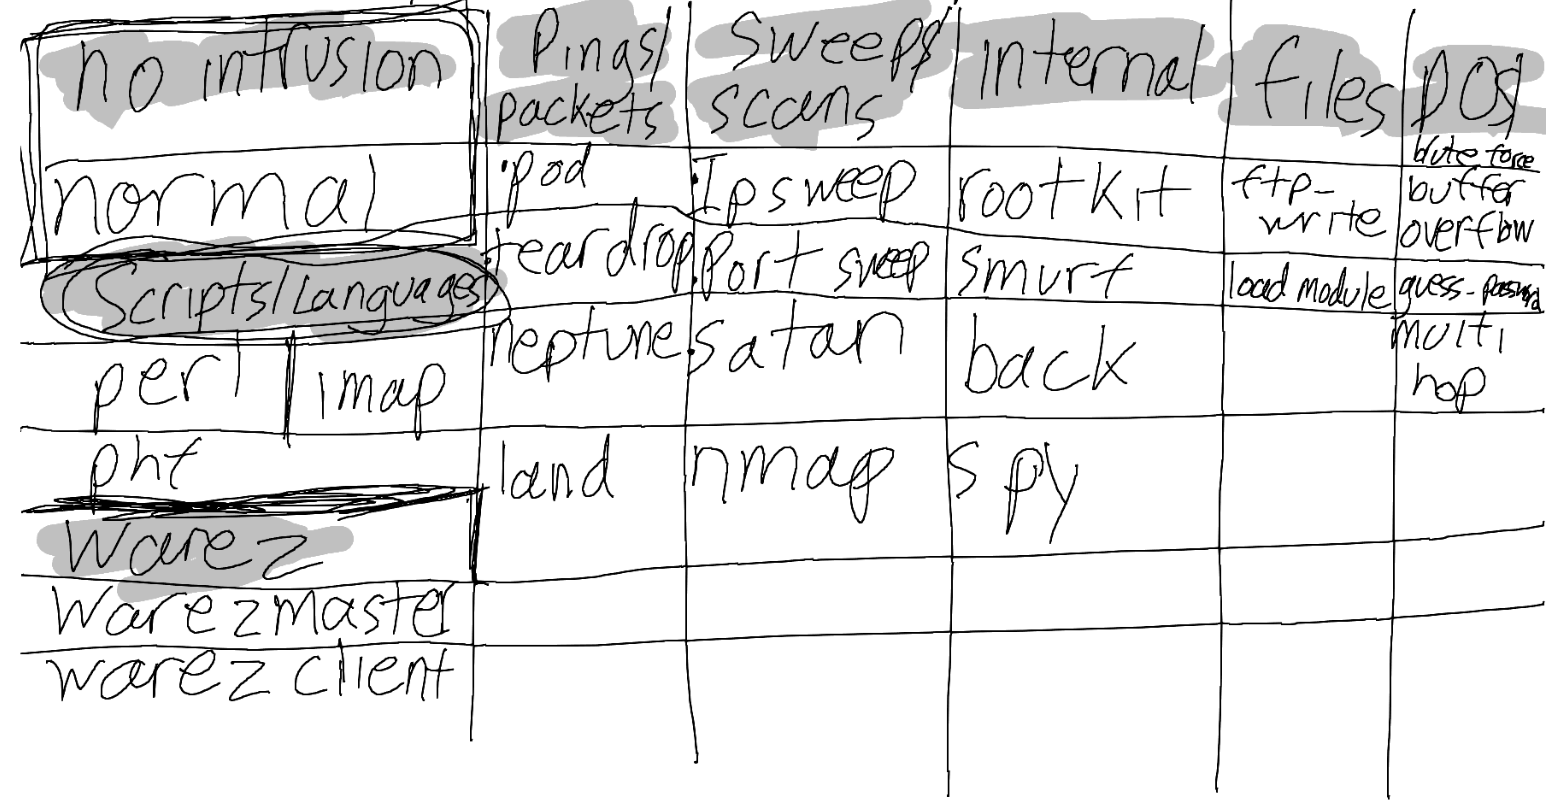

In [ ]:
display.Image('./notebooks/Supernote/Potential Cluster Groupings.png')

After splitting up the different intrusions into categories represented by the highlighted boxes above, it appeared that there were 8 tentative categories based on a casual sort through the types. While there is nothing definitive about this sort, it should give us an insight to put 8 firmly within the range of number of clusters that we try. After trying a range of 10 values, my computer wasn't able to make it through one iteration of the loop for 160 minutes. I'm now trying with significantly less iterations in the loop, less iterations in the cluster formula and my GPU instead of CPU. 

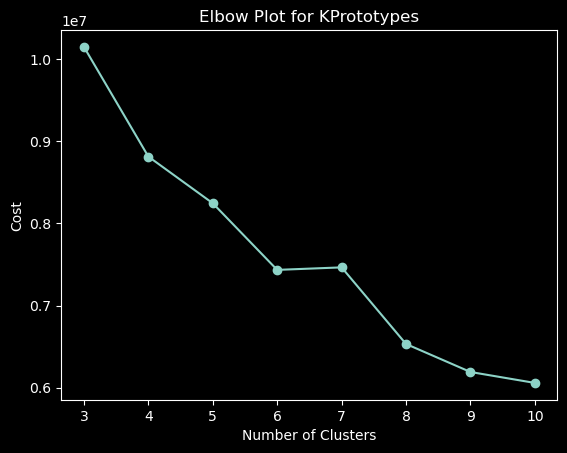

In [14]:
# Initialize cost list
cost = []

# Iterate for different amounts of centroids
for k in tqdm(range(3,11)):
    # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
    KProto = KPrototypes(n_clusters = k, init = 'Cao', n_init = 10, verbose = 1)
    # Use the KPrototypes model on the actual data
    cluster_labels = KProto.fit_predict(X_scaled, categorical = cat_col_index)
    # Append cost to the cost list for graphing later
    cost.append(KProto.cost_) 

# An elbow plot of k vs the cost function to try to find the optimal k
plt.plot(range(3,11), cost, marker = 'o');
plt.xlabel('Number of Clusters');
plt.ylabel('Cost');
plt.title('Elbow Plot for KPrototypes');

There is a weird increase in the cost function from 6 clusters to 7 clusters. This is because some of the features are categorical. I will now change Gamma to be 0.75 to de-emphasize the categorical variables so that it will be a clean cost descent.

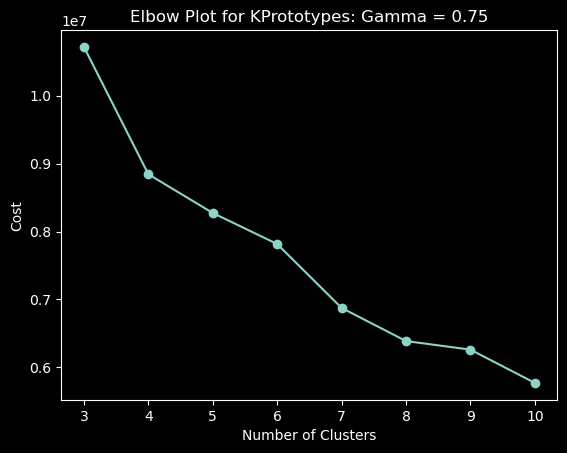

In [25]:
# Initialize cost list
cost_g75 = []

# Iterate for different amounts of centroids
for k in tqdm(range(3,11)):
    # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
    KProto = KPrototypes(n_clusters = k, init = 'Cao', n_init = 10, gamma = .75, verbose = 0)
    # Use the KPrototypes model on the actual data
    cluster_labels = KProto.fit_predict(X_scaled, categorical = cat_col_index)
    # Append cost to the cost list for graphing later
    cost_g75.append(KProto.cost_) 

# An elbow plot of k vs the cost function to try to find the optimal k
plt.plot(range(3,11), cost_g75, marker = 'o');
plt.xlabel('Number of Clusters');
plt.ylabel('Cost');
plt.title('Elbow Plot for KPrototypes: Gamma = 0.75');

Since there is no clear elbow in this graph it makes the most sense to use a gap statistic to for a more rigorous answer. The only gap statistic packages that I can install use pip instead of conda. I have created a separate environment to run those calculations and will copy and paste the code with the results here. Before I do that I need to export X_scaled to the new environment so I don't have to process the data again.

In [9]:
# Save X_scaled
X_scaled.to_csv('./data/interim/X_scaled.csv')

In [ ]:
# Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
KProto = KPrototypes(n_clusters = 8, init = 'Cao', n_init = 10, verbose = 1)
# Use the KPrototypes model on the actual data
cluster_labels = KProto.fit_predict(X_scaled, categorical = cat_col_index)

In [15]:
#data['clusters'] = cluster_labels
clusters = list(cluster_labels)
clusters_df = pd.DataFrame({'cluster':clusters})
clusters_df.to_csv('./data/interim/clusters.csv')

    Although I now have generated clusters and labeled each observation, I need a way to validate the existence of the clusters' structure in the data. The most straightforward way to evaluate the structure is a silhouette score which measures the distance or dissimilarity from other cluster's centroids (center of the cluster) compared to the dissimilarity to its own centroid. The closer a point is to its own centroid, while being far away from other centroids, the clearer it is that the structure is clustered. Unfortunately, when I ran the computation in R, the dataset was so large that the dissimilarity matrix (store of all the distances) returned a 900+ GB vector. That is far outside the ability of my computer or any normal commercial computer to handle. Even if I were to use just a tenth of the dataset for a representative sample, that would still generate over 28 billion cells. As such I have to use different algorithms that are not as direct but can still lend some insight into validity of the clustering structure. 

In [7]:
# Initialize Rand Index, Normalized Mutual Index, Fowlkes-Mallow
Rand, NMi, FMi = [], [], []

# The elbow plots indicated that the optimal k-value was between 6-8 This will hopefull give us some understanding
for k in tqdm(range(6,9)):
    # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
    KProto = KPrototypes(n_clusters = k, init = 'Cao', n_init = 10, verbose = 0)
    # Use the KPrototypes model on the actual data
    cluster_labels = KProto.fit_predict(X_scaled, categorical = cat_col_index)
    # Create many representative samples to get rid of any possible bad luck
    for i in range(5):
        # Create Bootstrap dataset with the same index as before so that I can find the original clusters as well
        bootstrap = X_scaled.sample(frac = 0.2, replace = True)
        # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
        KProto = KPrototypes(n_clusters = k, init = 'random', n_init = 10, verbose = 0)
        # Use the KPrototypes model on the actual data
        bootstrap_labels = KProto.fit_predict(bootstrap, categorical = cat_col_index)
        # Create Original Dataset's lables for bootstrapped data
        orig_value = [cluster_labels[i] for i in bootstrap.index]
        # Rand index calculation
        Rand.append(adjusted_rand_score(orig_value, bootstrap_labels))
        # Normalized Mutual index calculation
        NMi.append(normalized_mutual_info_score(orig_value, bootstrap_labels))
        # Fowlkes Mallow Index calculation
        FMi.append(fowlkes_mallows_score(orig_value, bootstrap_labels))

    # Print out the results for each Value of K
    print(f"K = {k}")
    print(f"Adjusted Rand Index: {np.mean(Rand)}     Normalized Mutual Index: {np.mean(NMi)}     Fowlkes Mallow Index: {np.mean(FMi)}")

 33%|███▎      | 1/3 [1:01:37<2:03:14, 3697.08s/it]

K = 6
Adjusted Rand Index: 0.8894501077101736     Normalized Mutual Index: 0.8873246516672953     Fowlkes Mallow Index: 0.9440910791463004


 67%|██████▋   | 2/3 [2:06:58<1:03:48, 3828.89s/it]

K = 7
Adjusted Rand Index: 0.9025865030551978     Normalized Mutual Index: 0.9124404909097266     Fowlkes Mallow Index: 0.9515153329286624


100%|██████████| 3/3 [3:16:56<00:00, 3938.97s/it]  

K = 8
Adjusted Rand Index: 0.8943602650541045     Normalized Mutual Index: 0.894223063479141     Fowlkes Mallow Index: 0.9462829744226278


Since this is a comparison between the whole dataset and a subset of the dataset I wasn't conviced that the similarity scores are valid proofs for the existence of a structure. As such I clustered a dataset that was completely random with no structure and ran the same similarity test to see if this method could determine if there was no cluster there. Since none of the results returned a score of above 

In [3]:
# Test a random dataset's similarity score
# set random seed for reproducibility
np.random.seed(123)

# create categorical columns
cat_col1 = pd.Series(np.random.choice(['A', 'B', 'C'], size=1000))
cat_col2 = pd.Series(np.random.choice(['X', 'Y', 'Z'], size=1000))

# create numerical columns
num_cols = pd.DataFrame(np.random.randn(1000, 8), columns=['Num1', 'Num2', 'Num3', 'Num4', 'Num5', 'Num6', 'Num7', 'Num8'])

# concatenate categorical and numerical columns
df = pd.concat([cat_col1, cat_col2, num_cols], axis=1)

# set column names for categorical columns
df.columns = ['Cat1', 'Cat2', 'Num1', 'Num2', 'Num3', 'Num4', 'Num5', 'Num6', 'Num7', 'Num8']

# Perform the clustering for the dataset
KProto = KPrototypes(n_clusters = 8, init = 'cao', n_init = 10, verbose = 0)
# Use the KPrototypes model on the actual data
labels = KProto.fit_predict(df, categorical = [0,1])


# Create Bootstrap dataset with the same index as before so that I can find the original clusters as well
bootstrap = df.sample(frac = 0.2, replace = True)

# Re run the clustering for the sample
KProto = KPrototypes(n_clusters = 8, init = 'random', n_init = 10, verbose = 0)
# Use the KPrototypes model on the actual data
bootstrap_labels = KProto.fit_predict(bootstrap, categorical = [0,1])

# Create Original Dataset's lables for bootstrapped data
orig_value = [labels[i] for i in bootstrap.index]

# Rand index calculation
Rand = adjusted_rand_score(orig_value, bootstrap_labels)

# Normalized Mutual index calculation
NMi = normalized_mutual_info_score(orig_value, bootstrap_labels)

# Fowlkes Mallow Index calculation
FMi = fowlkes_mallows_score(orig_value, bootstrap_labels)

print(f"Adjusted Rand Index: {Rand}")
print(f"Normalized Mutual Index: {NMi}")
print(f"Fowlkes Mallow Index: {FMi}")

Adjusted Rand Index: 0.18599893493315675
Normalized Mutual Index: 0.34959850252909774
Fowlkes Mallow Index: 0.289448260165949


One last way to try to confirm the clusters validity is through principal component analysis (PCA). PCA allows us to boil down 41 different features into 2 composite features that we can visualize on a graph.

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 119501, ncost: 7810402.957629502
Run: 1, iteration: 2/100, moves: 7605, ncost: 7773068.386199402
Run: 1, iteration: 3/100, moves: 2147, ncost: 7766733.246141826
Run: 1, iteration: 4/100, moves: 900, ncost: 7761888.566249102
Run: 1, iteration: 5/100, moves: 367, ncost: 7761739.22499957
Run: 1, iteration: 6/100, moves: 33, ncost: 7761739.099240371
Run: 1, iteration: 7/100, moves: 1, ncost: 7761739.099076475
Run: 1, iteration: 8/100, moves: 0, ncost: 7761739.099076475
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 42594, ncost: 7954854.166037118
Run: 2, iteration: 2/100, moves: 54698, ncost: 7479441.246147748
Run: 2, iteration: 3/100, moves: 8864, ncost: 7471407.596919888
Run: 2, iteration: 4/100, moves: 49, ncost: 7471388.089582722
Run: 

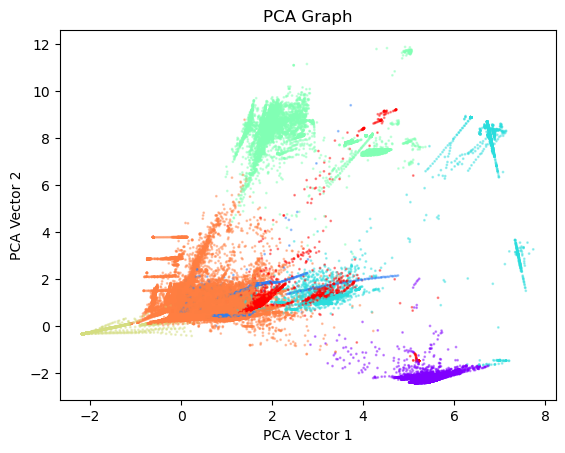

In [39]:
# First create the dummy variables for PCA
dummy_df = pd.get_dummies(X_scaled, 
                          columns = ['protocol_type', 'service', 'flag'],
                          prefix = ['protocol_type', 'service', 'flag'],
                          prefix_sep = '/')

# Create the PCA object since the data has already been scaled
pca = PCA(n_components = 2)
# fit the data
pca_vectors = pca.fit_transform(dummy_df)

# Generate the clusters for K = 7 
# Use K-Prototype to generate a model. 
KProto = KPrototypes(n_clusters = 7, init = 'Cao', n_init = 10, verbose = 1)
# Use the KPrototypes model on the actual data
cluster_labels = KProto.fit_predict(X_scaled, categorical = cat_col_index)

# Graph the two vectors to see if there are clusters
plt.style.use('default');
plt.scatter(pca_vectors[:,0], pca_vectors[:,1], 
            c = cluster_labels, cmap = 'rainbow',
            s = 1, alpha = 0.4);
plt.xlabel('PCA Vector 1');
plt.ylabel('PCA Vector 2');
plt.title('PCA Graph');


It is pretty clear with this graph that clusters exist. Some of the clusters that are shown in the PCA graph may seem to be bad clusters but that is because those clusters are from the initial dataset which had variables that PCA would have a hard time capturing. It is important to note that there were 41 different features in the dataset. If I had selected 3 components instead of 2 more of these groupings would have made sense. 
Now that we have a clear clustering of the data we can finally save the data.

In [42]:
data['k=7'] = cluster_labels
data.to_csv(r'./data/processed/data+k=7.csv')

Now that we have the cluster labels in the dataset itself we can see how the cluster labels interact with the types of intrusions.

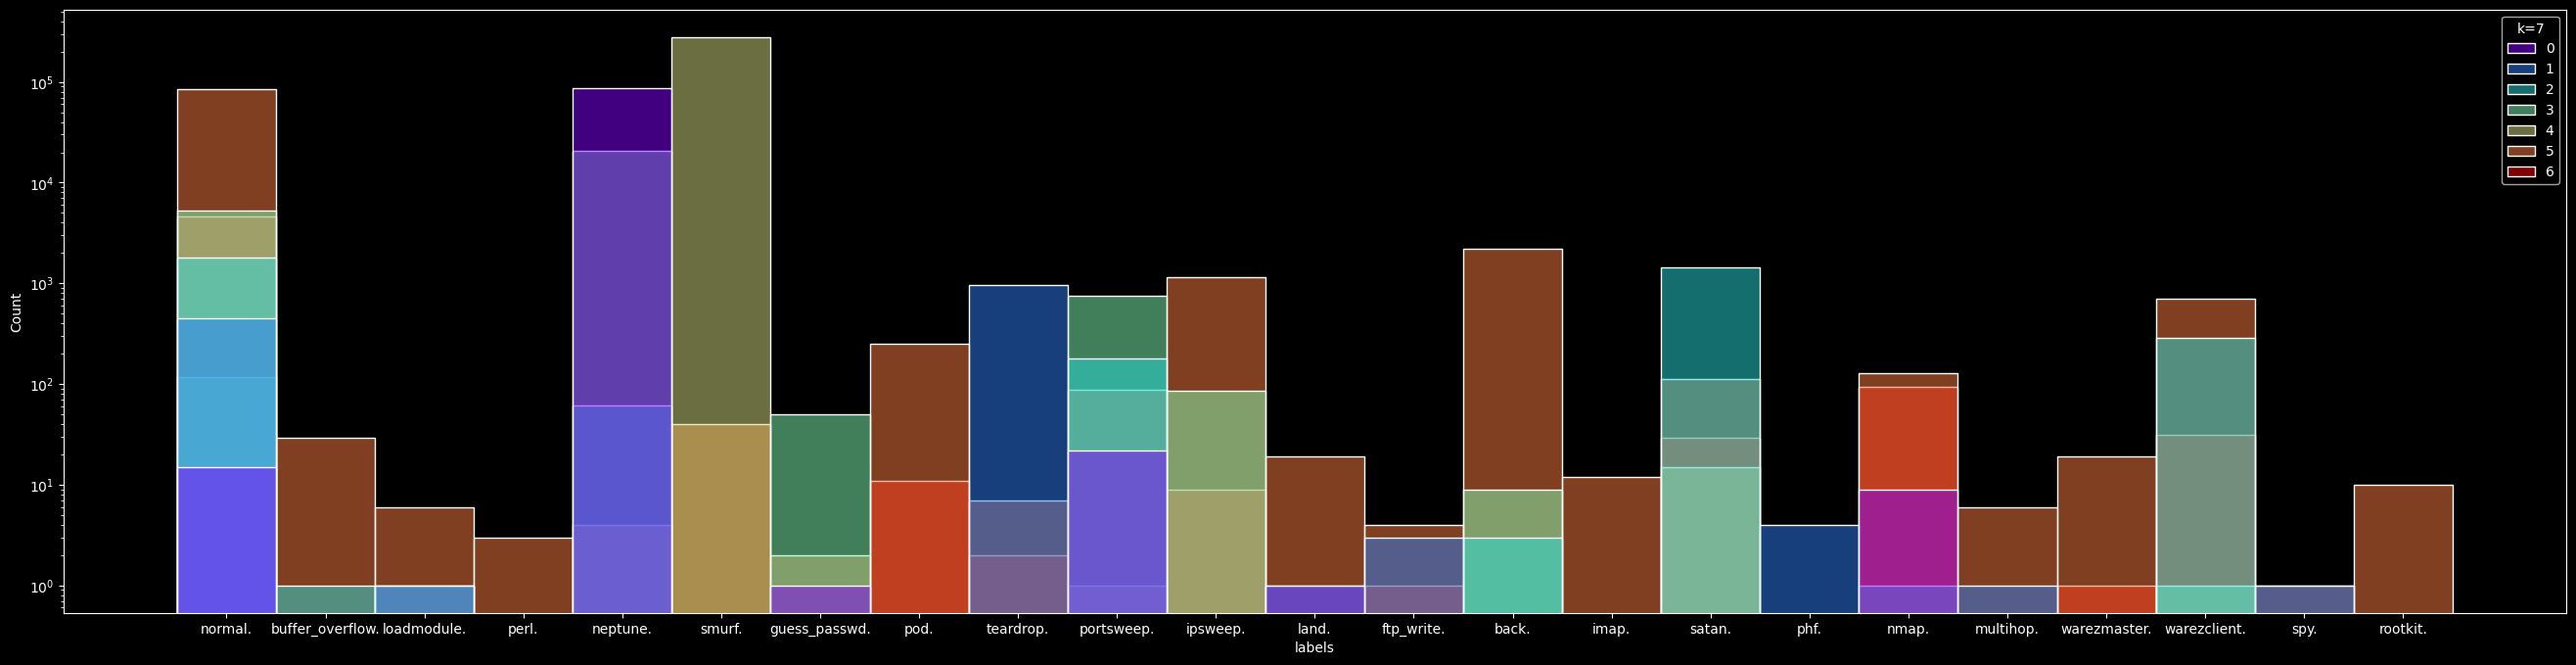

smurf.              0.568378
neptune.            0.216997
normal.             0.196909
back.               0.004459
satan.              0.003216
ipsweep.            0.002524
portsweep.          0.002105
warezclient.        0.002065
teardrop.           0.001982
pod.                0.000534
nmap.               0.000468
guess_passwd.       0.000107
buffer_overflow.    0.000061
land.               0.000043
warezmaster.        0.000040
imap.               0.000024
rootkit.            0.000020
loadmodule.         0.000018
ftp_write.          0.000016
multihop.           0.000014
phf.                0.000008
perl.               0.000006
spy.                0.000004
Name: labels, dtype: float64


In [43]:
# import dataset with K=7 clusters
dataK7 = pd.read_csv(r'./data/processed/data+k=7.csv')

#Switch back to dark mode for my eyes
plt.style.use('dark_background')

# Change figure size so that the x tick marks are readable
plt.figure(figsize = (33,8))

# Create a histogram of the types of network intrusions including non-intrusions
sns.histplot(data = data, x = 'labels', hue = 'k=7', palette = 'rainbow')

# Set the scale to log so that we can have a much better visualization of the attacks
plt.yscale('log')

plt.show()

# Give context to how much each intrusion occurs
print(data['labels'].value_counts(normalize = True))

Now that we have the clusters and have visualized them relative to the attacks we need to calculate how each cluster correlates with each attack. Even if every cluster has non attacks, the frequency that a cluster is in the normal range combined with how dangerous the attacks they are associated with can provide valuable insight into what the markers are for a devastating attack.

100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


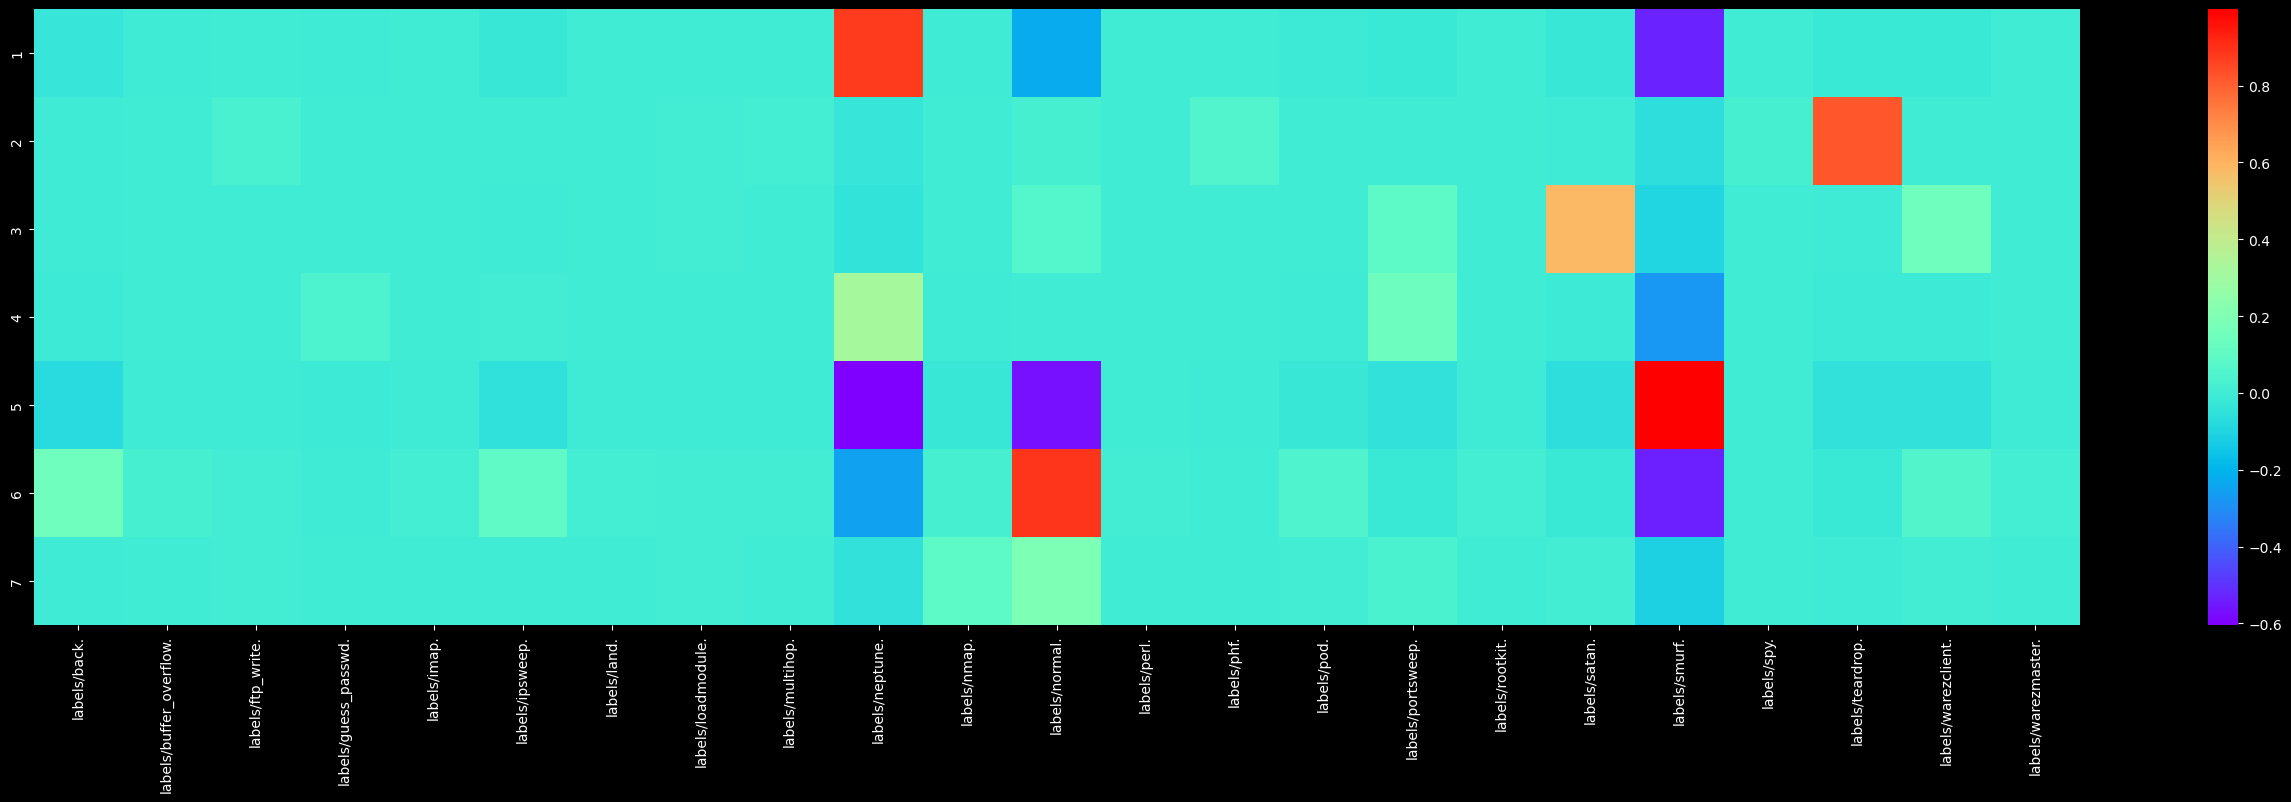

In [128]:
#Create a dummy matrix for the types of intrusions and labels
lab_clus_dummy = pd.get_dummies(dataK7, columns = ['labels', 'k=7'], 
                                prefix = ['labels', 'k=7'], 
                                prefix_sep = '/')
# Filter out for only the labels and clusters
lab_clus_dummy = lab_clus_dummy.loc[:, 'labels/back.':]

corr_matrix = np.zeros((23,7))

for k in tqdm(range(23, len(lab_clus_dummy.columns))):
    for label in range(23):
        corr_matrix[label, k-23] = lab_clus_dummy.iloc[:,k].T.corr(other = lab_clus_dummy.iloc[:,label])



corr_df = pd.DataFrame(corr_matrix, 
                       columns = range(1,8),
                       index = lab_clus_dummy.columns[:23])


# create a heatmap of correlation matrix to see each clusters highest intrusion correlations
plt.figure(figsize = (33,8))
sns.heatmap(corr_df.T, cmap = 'rainbow');

In [60]:
# Compute the correlation matrix
corr_matrix = lab_clus_dummy.corr()

# Set the threshold for correlation coefficient
threshold = 0.7

# Find the indices of the elements that satisfy the threshold condition
high_corr_indices = np.where(np.abs(corr_matrix) > threshold)

# Get the pairs of column names that have a correlation coefficient above the threshold
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) for i, j in zip(*high_corr_indices) if i < j]

# Print the pairs of column names
print(high_corr_pairs)

[('labels/neptune.', 'k=7/0'), ('labels/normal.', 'k=7/5'), ('labels/smurf.', 'k=7/4'), ('labels/teardrop.', 'k=7/1')]
